#### Importing Libraries

In [1]:
#impoting libraries
import os
import sys
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import re
import glob
#import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.models import Sequential
get_ipython().magic('matplotlib inline')
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense, Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D, Dropout, Flatten, Reshape, Activation

from sklearn.metrics import log_loss
from tensorflow.keras.models import Model
import csv
from tensorflow.keras import backend as K

In [2]:
# The function below will sort the files in numberical order 
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
img_path = sorted(glob.glob('/home/mchou001/train/**/*.png'), key = numericalSort) # importing training image files (40 ETDs -- 5,605 images)

In [4]:
img_test_path = sorted(glob.glob('/home/mchou001/test/**/*.png'), key = numericalSort) # importing test image files (10 ETDs -- 735 images)

In [5]:
classes = pd.read_csv("labels.csv")

In [6]:
classes.head()

,file_id,labels
0,"File Name: etd1_page1.png,",Label-TitlePage
1,"File Name: etd1_page2.png,",Label-Dedication
2,"File Name: etd1_page3.png,",Label-Abstract
3,"File Name: etd1_page4.png,",Label-Acknowledgement
4,"File Name: etd1_page5.png,",Label-TableofContent


In [7]:
labels = classes['labels'] #consist of train_labels

In [8]:
labels.value_counts()

Label-Chapters                       4018
Label-Appendices                     1001
Label-Other                           160
Label-ReferenceList                   109
Label-TableofContent                   85
Label-ListofTables                     68
Label-Abstract                         45
Label-TitlePage                        43
Label-DedicationOrAcknowledgement      37
Label-ListofFigures                    29
Label-GeneralAbstract                   4
Label-Dedication                        3
Label-Acknowledgement                   3
Name: labels, dtype: int64

In [29]:
test_classes = pd.read_csv("test_labels.csv")

In [30]:
test_labels = test_classes['labels'] #consist of test_labels

#### Map image path and class labels

In [31]:
img_path_label_map = list(zip(img_path, labels))

In [32]:
img_path_test_label_map = list(zip(img_test_path, labels))

In [33]:
df = pd.DataFrame(img_path_label_map, columns = ['filename', 'labels'])
df.to_csv('train.csv', encoding = 'utf-8', index= None)

In [34]:
train = pd.read_csv("train.csv")

In [35]:
train.head()

,filename,labels
0,/home/mchou001/train/1/1.png,Label-TitlePage
1,/home/mchou001/train/1/2.png,Label-Dedication
2,/home/mchou001/train/1/3.png,Label-Abstract
3,/home/mchou001/train/1/4.png,Label-Acknowledgement
4,/home/mchou001/train/1/5.png,Label-TableofContent


In [36]:
df = pd.DataFrame(img_path_test_label_map, columns = ['filename', 'labels'])
df.to_csv('test.csv', encoding = 'utf-8', index= None)

In [37]:
test = pd.read_csv("test.csv")

In [38]:
test.head()

,filename,labels
0,/home/mchou001/test/41/1.png,Label-TitlePage
1,/home/mchou001/test/41/2.png,Label-Dedication
2,/home/mchou001/test/41/3.png,Label-Abstract
3,/home/mchou001/test/41/4.png,Label-Acknowledgement
4,/home/mchou001/test/41/5.png,Label-TableofContent


### Data Augmentation

In [106]:
val_split = 0.20
# Image augmentations
train_generator = ImageDataGenerator(
    vertical_flip=True,         # vertical transposition
    horizontal_flip=True,       # horizontal transposition
    rotation_range=90,          # random rotation at 90 degrees
    height_shift_range=0.1,     # shift the height of the image 30%
    width_shift_range=0.1,      # shift the width of the image 50%
    brightness_range=[0.1, 0.5], # specify the range in which to decrease/increase brightness
    validation_split=val_split,      # 10% of the data will be used for validation at end of each epoch
    preprocessing_function=preprocess_input # VGG16 preprocessing
)

In [107]:
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

#### Reading training images and resize it to the VGG16 accepted target size

In [41]:
train_img = []
for i in range(len(train)):
    img = image.load_img(train['filename'][i], target_size=(224, 224))
    img_arr = image.img_to_array(img)
    train_img.append(img_arr)

train_img = np.array(train_img)
#traingen = train_generator.flow(train_img,batch_size=32)

#train_img = preprocess_input(train_img)

#### Checking some of the samples after augmentation

In [ ]:
# for i in range(9):
#     plt.subplot(330+1+i) # defining the subplots
#     batch = traingen.next()  # generate batch of images 
#     image = batch[0].astype('uint8') # convert to unsigned integers to view
#     plt.imshow(image)

# plt.show()

In [43]:
print(train_img.shape)
print(train_img.size)
print(len(train_img))

(5605, 224, 224, 3)
843709440
5605


#### Reading test images and resize it to the VGG16 accepted target size

In [44]:
test_img = []
for i in range(len(test)):
    img = image.load_img(test['filename'][i], target_size = (224,224))
    img_arr = image.img_to_array(img)    
    test_img.append(img_arr)

test_img = np.array(test_img)
testgen = test_generator.flow(test_img,batch_size=32)
#test_img = preprocess_input(test_img)

In [45]:
print(test_img.shape)
print(test_img.size)
print(len(test_img))

(735, 224, 224, 3)
110638080
735


#### Encoding Train labels to integers

In [46]:
y_classes = np.asarray(train['labels'])
le = LabelEncoder()
le.fit(list(y_classes))
train_y = le.transform(list(y_classes))
labels_and_integers = dict(zip(train_y, y_classes))

In [47]:
labels_and_integers

{12: 'Label-TitlePage',
 4: 'Label-Dedication',
 0: 'Label-Abstract',
 1: 'Label-Acknowledgement',
 11: 'Label-TableofContent',
 7: 'Label-ListofFigures',
 8: 'Label-ListofTables',
 3: 'Label-Chapters',
 2: 'Label-Appendices',
 9: 'Label-Other',
 10: 'Label-ReferenceList',
 5: 'Label-DedicationOrAcknowledgement',
 6: 'Label-GeneralAbstract'}

In [48]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12], y=[12  4  0 ... 10 10 10] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [49]:
class_weights_dict = dict(zip(le.transform(list(le.classes_)), class_weights))
class_weights_dict

{0: 9.581196581196581,
 1: 143.71794871794873,
 2: 0.43072312303081534,
 3: 0.10730558639966306,
 4: 143.71794871794873,
 5: 11.652806652806653,
 6: 107.78846153846153,
 7: 14.86737400530504,
 8: 6.340497737556561,
 9: 2.6947115384615383,
 10: 3.9555398729710656,
 11: 5.072398190045249,
 12: 10.026833631484795}

In [50]:
print(train_y.shape)
print(train_y)
print(len(train_y))

(5605,)
[12  4  0 ... 10 10 10]
5605


#### Encoding Test labels to integers

In [134]:
test_y_classes = np.asarray(test['labels'])
le = LabelEncoder()
le.fit(list(test_y_classes))
test_y = le.transform(list(test_y_classes))
labels_and_integers_test = dict(zip(test_y, test_y_classes))

In [135]:
labels_and_integers_test

{11: 'Label-TitlePage',
 4: 'Label-Dedication',
 0: 'Label-Abstract',
 1: 'Label-Acknowledgement',
 10: 'Label-TableofContent',
 6: 'Label-ListofFigures',
 7: 'Label-ListofTables',
 3: 'Label-Chapters',
 2: 'Label-Appendices',
 8: 'Label-Other',
 9: 'Label-ReferenceList',
 5: 'Label-DedicationOrAcknowledgement'}

In [52]:
print(test_y.shape)

(735,)


In [53]:
print(test_y)

[11  4  0  1 10 10  6  6  7  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2 11  0  1 10 10 10 10  8  8  8  8  8  8  8
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3

# VGG16 Model

### Defining metrics (F1, recall, precision)

In [54]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [55]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [56]:
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [108]:
def vgg16_model(input_shape, num_classes):
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='sigmoid')(top_model)
    top_model = Dense(1072, activation='sigmoid')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(num_classes, activation='softmax')(top_model)
    model = Model(conv_base.input, output_layer)
    
    #freezing top 4 layers (i.e., non-trainable)
    for layer in conv_base.layers[:4]:
        layer.trainable = False
    
    #optim = Adam(learning_rate = 0.001)
    sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

#### Split the dataset to train and validation set

In [109]:
X_train, X_valid, Y_train, Y_valid = train_test_split(train_img, train_y, stratify=train_y)

In [110]:
X_train.shape

(4203, 224, 224, 3)

In [111]:
Y_train.shape

(4203,)

In [112]:
X_valid.shape

(1402, 224, 224, 3)

In [113]:
Y_valid.shape

(1402,)

In [114]:
np.unique(Y_train, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([  34,    2,  750, 3013,    2,   28,    3,   22,   51,  120,   82,
          64,   32]))

In [115]:
np.unique(Y_valid, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([  11,    1,  251, 1005,    1,    9,    1,    7,   17,   40,   27,
          21,   11]))

In [116]:
#np.unique(X_train, return_counts=True)

In [117]:
input_shape = (224, 224, 3)
num_classes = 13
batch_size = 32
nb_epoch = 30

In [118]:
model_vgg16 = vgg16_model(input_shape, num_classes)

In [119]:
model_vgg16.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [120]:
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min', verbose=1) # to get the best model

In [121]:
traingen = train_generator.flow(X_train, Y_train, batch_size=batch_size)

In [122]:
valigen = train_generator.flow(X_valid, Y_valid, batch_size=batch_size)

In [123]:
vgg_history = model_vgg16.fit(traingen, validation_data = valigen, epochs=nb_epoch, class_weight = class_weights, callbacks=[es])

Epoch 1/30
132/132 [==============================] - 115s 871ms/step - loss: 0.9628 - acc: 0.7216 - val_loss: 0.8645 - val_acc: 0.7382
Epoch 2/30
132/132 [==============================] - 101s 769ms/step - loss: 0.8391 - acc: 0.7471 - val_loss: 0.8301 - val_acc: 0.7603
Epoch 3/30
132/132 [==============================] - 103s 780ms/step - loss: 0.7998 - acc: 0.7692 - val_loss: 0.7785 - val_acc: 0.7632
Epoch 4/30
132/132 [==============================] - 105s 792ms/step - loss: 0.7660 - acc: 0.7721 - val_loss: 0.7728 - val_acc: 0.7625
Epoch 5/30
132/132 [==============================] - 100s 754ms/step - loss: 0.7318 - acc: 0.7844 - val_loss: 0.7359 - val_acc: 0.7846
Epoch 6/30
132/132 [==============================] - 105s 793ms/step - loss: 0.7255 - acc: 0.7861 - val_loss: 0.7449 - val_acc: 0.7718
Epoch 7/30
132/132 [==============================] - 104s 787ms/step - loss: 0.6946 - acc: 0.7868 - val_loss: 0.7285 - val_acc: 0.7703
Epoch 8/30
132/132 [============================

In [50]:
#model_vgg16.save('page_classification_vgg16.h5')

In [124]:
model_vgg16.save('page_classification_vgg16-084acc.h5')

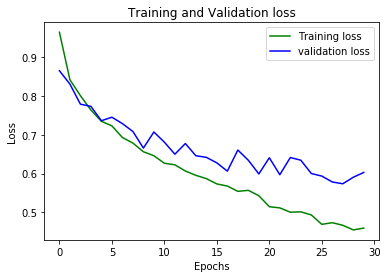

In [125]:
loss_train = vgg_history.history['loss']
loss_val = vgg_history.history['val_loss']
plt.plot(loss_train, 'g', label='Training loss')
plt.plot(loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

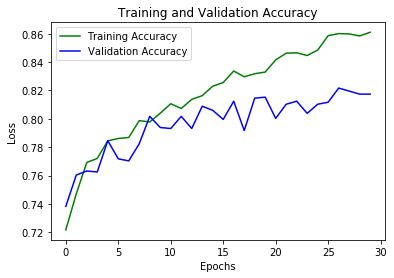

In [126]:
loss_train = vgg_history.history['acc']
loss_val = vgg_history.history['val_acc']
plt.plot(loss_train, 'g', label='Training Accuracy')
plt.plot(loss_val, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predict the model on new images (i.e., Test image)

In [127]:
y_pred = model_vgg16.predict(X_valid, batch_size=64, verbose=1)

1402/1402 [==============================] - 3s 2ms/sample


In [128]:
from sklearn.metrics import classification_report
y_predicted = np.argmax(y_pred, axis=1)

In [129]:
print(classification_report(Y_valid, y_predicted))

              precision    recall  f1-score   support

           0       0.17      0.09      0.12        11
           1       0.00      0.00      0.00         1
           2       0.79      0.42      0.55       251
           3       0.82      0.99      0.89      1005
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         7
           8       1.00      0.71      0.83        17
           9       0.67      0.20      0.31        40
          10       0.67      0.22      0.33        27
          11       0.67      0.19      0.30        21
          12       0.75      0.55      0.63        11

    accuracy                           0.81      1402
   macro avg       0.42      0.26      0.30      1402
weighted avg       0.79      0.81      0.77      1402



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [130]:
y__test_pred = model_vgg16.predict(test_img, verbose=1)

735/735 [==============================] - 1s 2ms/sample


In [133]:
y_test_predicted = np.argmax(y__test_pred, axis=1)
print(classification_report(test_y, y_test_predicted))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         2
           2       0.11      0.15      0.13        62
           3       0.84      0.81      0.83       613
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00        24
           9       0.00      0.00      0.00        10
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00         4
          12       0.00      0.00      0.00         0

    accuracy                           0.69       735
   macro avg       0.07      0.07      0.07       735
weighted avg       0.71      0.69      0.70       735



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [91]:
# pred = []
# for i in range(len(test)):
#     img = image.load_img(test['filename'][i], target_size = (224,224))
#     predict_labels = test_labels[np.argmax(y_pred, axis=1)]
#     pred.append(predict_labels)
#     print(predict_labels)
#     plt.figure(figsize=(20,10))
#     plt.imshow(img)
#     plt.show()

In [ ]:
pred_val = pd.DataFrame(pred, columns = ['predicted_label'])
pred_val.to_csv('result.csv', encoding = 'utf-8', index= None)

In [ ]:
df1 = pd.read_csv('result.csv')
df2 = pd.read_csv('test.csv')

df3 = df1['predicted_label']
df4 = df2['labels']
result = pd.concat([df3, df4], axis = 1, sort = False)
result.to_csv("output.csv", index = None, encoding = 'utf-8')

In [ ]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(df4, df3)
print("VGG16 Model Accuracy: {:.2f}%".format(acc * 100))

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(test_y, pred))